In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.base import BaseEstimator as base
from sklearn.base import RegressorMixin as regression
from sklearn.base import TransformerMixin as trans
from sklearn.base import ClassifierMixin as classf
from sklearn.base import MultiOutputMixin as multi
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_X_y, check_is_fitted, column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import as_float_array, check_random_state, check_array
from sklearn.preprocessing import OneHotEncoder

In [9]:
class PPR(base,regression,trans,classf,multi):
	
	def __init__(self, r=10, degree=3,example_weights='uniform', out_dim_weights='inverse-variance',
				 eps_stage=0.0001, eps_backfit=0.01, stage_maxiter=100,
				 backfit_maxiter=10, random_state=None, show_plots=True,
				 plot_epoch=50):

		
		# Save parameters to the object
		params = locals()
		for k, v in params.items():
			if k != 'self':
				setattr(self, k, v)

	def transform(self, X):
		check_is_fitted(self, '_alpha')
		X = check_array(X)
		return np.dot(X, self._alpha)

	def predict(self, X):
		
		# Check whether the PPR is trained, and if so get the projections.
		P = self.transform(X) # P is an n x r matrix.
		Y = sum([np.outer(self._f[j](P[:, j]), self._beta[:, j])
			for j in range(self.r)])
		# return single-dimensional output if Y has only one column
		return Y if Y.shape[1] != 1 else Y[:,0]

	def fit(self, X, Y):
		# some stuff to make this jazz pass sklearn's check_estimator()
		X, Y = check_X_y(X, Y, multi_output=True)
		if Y.ndim == 2 and Y.shape[1] == 1:
			Y = column_or_1d(Y, warn=True)
		if Y.ndim == 1: # standardize Y as 2D so the below always works
			Y = Y.reshape((-1,1)) # reshape returns a view to existing data

		self._random = check_random_state(self.random_state)
		if isinstance(self.example_weights, str) and self.example_weights == 'uniform':
			self._example_weights = np.ones(X.shape[0])
		elif isinstance(self.example_weights, np.ndarray):
			if X.shape[0] != self.example_weights.shape[0]:
				raise ValueError('example_weights provided to the constructor' +
					' have dimension ' + str(self.example_weights.shape[0]) +
					', which disagrees with the size of X: ' + str(X.shape[0]))
			else:
				self._example_weights = self.example_weights

		if isinstance(self.out_dim_weights, str) and self.out_dim_weights == 'inverse-variance':
			variances = Y.var(axis=0)
			if max(variances) == 0: # if all zeros, don't readjust weights
				variances = np.ones(Y.shape[1])
			else:
				variances[variances == 0] = max(variances)
			self._out_dim_weights = 1./variances
		elif isinstance(self.out_dim_weights, str) and self.out_dim_weights == 'uniform':
			self._out_dim_weights = np.ones(Y.shape[1])
		elif isinstance(self.out_dim_weights, np.ndarray):
			if Y.shape[1] != self.out_dim_weights.shape[0]:
				raise ValueError('out_dim_weights provided to the constructor' +
					' have dimension ' + str(self.out_dim_weights.shape[0]) +
					', which disagrees with the width of Y: ' + str(Y.shape[1]))
			else:
				self._out_dim_weights = self.out_dim_weights

		# Now that input and output dimensions are known, parameters vectors
		# can be initialized. Vectors are always stored vertically.
		self._alpha = self._random.randn(X.shape[1], self.r) # p x r
		self._beta = self._random.randn(Y.shape[1], self.r) # d x r
		self._f = [lambda x: x*0 for j in range(self.r)] # zero functions
		self._df = [None for j in range(self.r)] # no derivatives yet

		for j in range(self.r): # for each term in the additive model
			self._fit_stage(X, Y, j, True)
			self._backfit(X, Y, j, True)
		return self

	def _fit_stage(self, X, Y, j, fit_weights):
		# projections P = X*Alphas, P_j = X*alpha_j
		P = self.transform(X) # the n x r projections matrix
		R_j = Y - sum([np.outer(self._f[t](P[:, t]), self._beta[:, t].T) for t 
			in range(self.r) if t is not j]) # the n x d residuals matrix

		itr = 0 
		prev_loss = -np.inf
		loss = np.inf
		p_j = P[:,j] # n x 1, the jth column of the projections matrix
		while (abs(prev_loss - loss) > self.eps_stage and itr < self.stage_maxiter):			
			# To understand how to optimize each set of parameters assuming the
			# others remain constant, see math.pdf section 3.
			
			# find the f_j
			beta_j_w = self._out_dim_weights*self._beta[:, j] # weighted beta
			targets = np.dot(R_j, beta_j_w) / (
					  np.inner(self._beta[:, j], beta_j_w) + 1e-9)
			# Fit the targets against projections.
			self._f[j], self._df[j] = self._fit_2d(p_j, targets, j, itr)
			
			# find beta_j
			f = self._f[j](p_j) # Find the n x 1 vector of function outputs.
			f_w = self._example_weights*f # f weighted by examples
			self._beta[:, j] = np.dot(R_j.T, f_w) / (np.inner(f, f_w) + 1e-9)

			# find alpha_j
			if fit_weights:
				# Find the part of the Jacobians that is common to all
				J = -(self._df[j](p_j)*np.sqrt(self._example_weights)*X.T).T
				JTJ = np.dot(J.T, J)
				A = sum([self._out_dim_weights[k] * (self._beta[k, j]**2) * JTJ
					for k in range(Y.shape[1])])
				# Collect all g_jk vectors in to a convenient matrix G_j
				G_j = R_j - np.outer(self._f[j](p_j), self._beta[:, j].T)
				b = -sum([self._out_dim_weights[k] * self._beta[k, j] *
					np.dot(J.T, G_j[:, k]) for k in range(Y.shape[1])])

				delta = np.linalg.lstsq(A.astype(np.float64, copy=False),
					b.astype(np.float64, copy=False), rcond=-1)[0]
				# TODO implement halving step if the loss doesn't decrease with
				# this update.
				alpha = self._alpha[:, j] + delta
				# normalize to avoid numerical drift
				self._alpha[:, j] = alpha/np.linalg.norm(alpha)

			# Recalculate the jth projection with new f_j and alpha_j
			p_j = np.dot(X, self._alpha[:, j])
			
			# Calculate mean squared error for this iteration
			prev_loss = loss
			# Subtract updated contribution of the jth term to get the
			# difference between Y and the predictions. 
			diff = R_j - np.outer(self._f[j](p_j), self._beta[:, j].T)
			# square the difference, multiply rows by example weights, multiply
			# columns by their weights, and sum to get the final loss
			loss = np.dot(np.dot(self._example_weights, diff**2),
				self._out_dim_weights)
			itr += 1

	def _backfit(self, X, Y, j, fit_weights):
		itr = 0
		prev_loss = -np.inf
		loss = np.inf
		while (abs(prev_loss - loss) > self.eps_backfit and itr < self.backfit_maxiter):
			for t in range(j):
				self._fit_stage(X, Y, t, fit_weights)

			prev_loss = loss
			diff = Y - self.predict(X).reshape(Y.shape)
			loss = np.dot(np.dot(self._example_weights, diff**2),
				self._out_dim_weights)
			itr += 1

	def _fit_2d(self, x, y, j, itr):
		fit = UnivariateSpline(x[np.argsort(x)], y[np.argsort(x)], w=self._example_weights,
				k=self.degree, s=len(y)*y.var(), ext=0)
		deriv = fit.derivative(1)

		if self.show_plots and (itr % self.plot_epoch == 0):
			plt.scatter(x, y)
			plt.title('stage ' + str(j) + ' iteration ' + str(itr))
			plt.xlabel('projections')
			plt.ylabel('residuals')
			xx = np.linspace(min(x), max(x), 100)
			yy = fit(xx)
			plt.plot(xx, yy, 'g', linewidth=1)
			plt.show()

		return fit, deriv



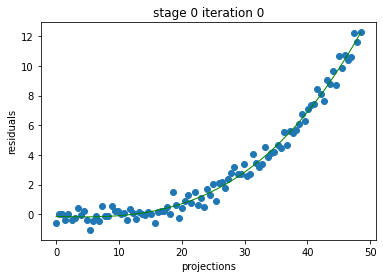

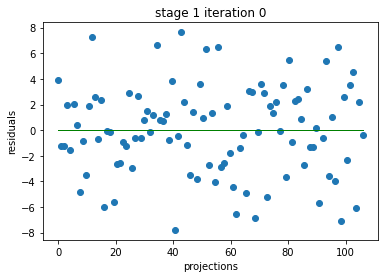

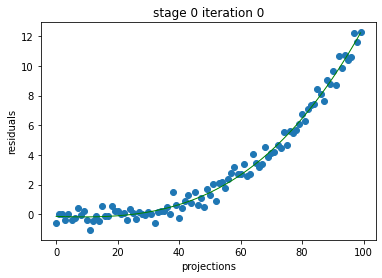

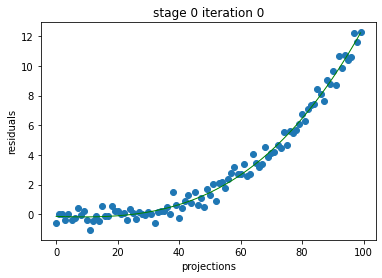

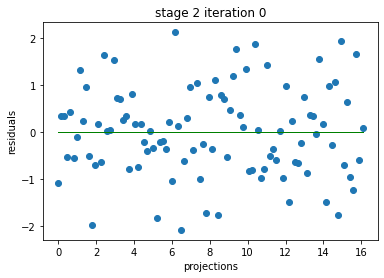

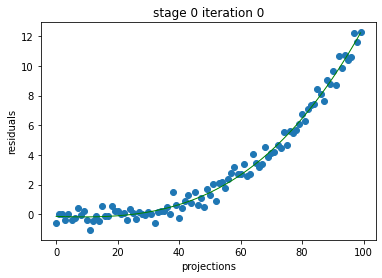

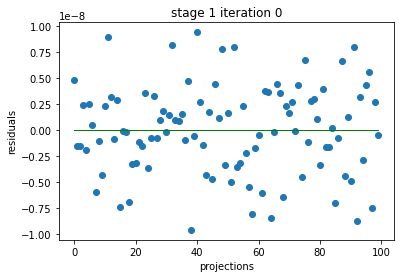

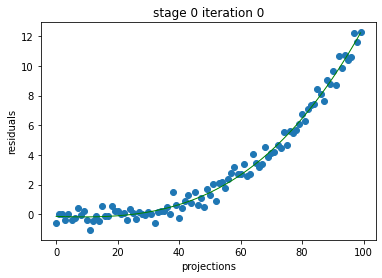

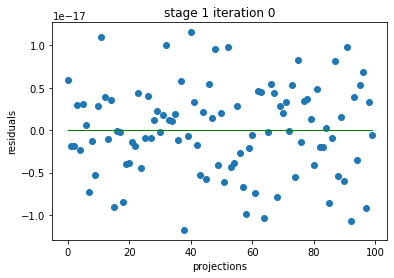

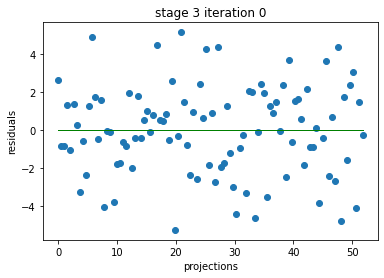

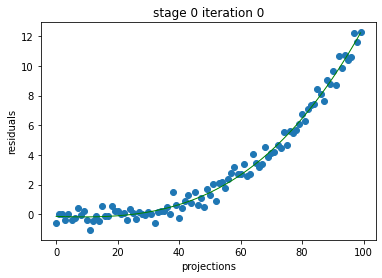

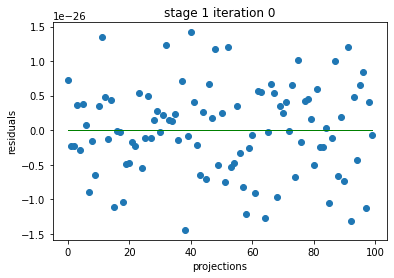

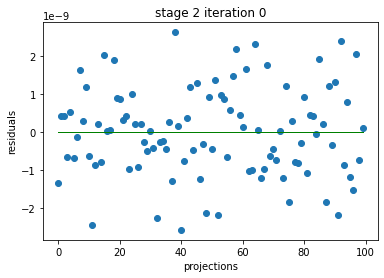

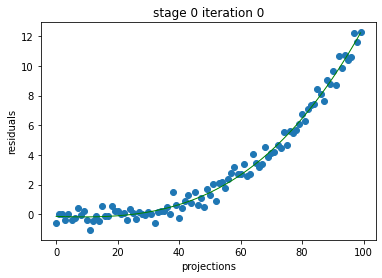

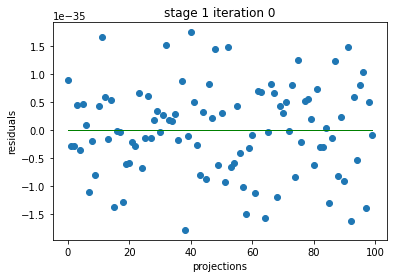

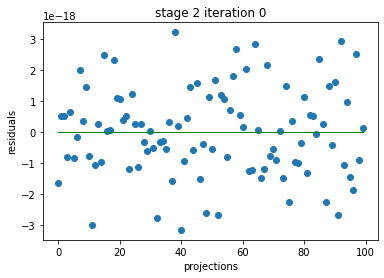

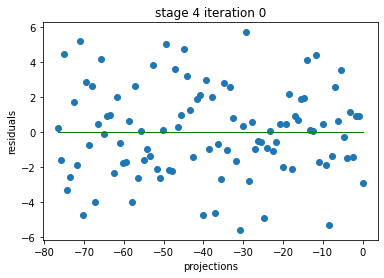

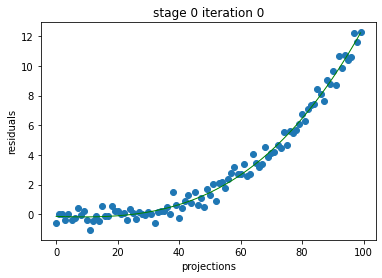

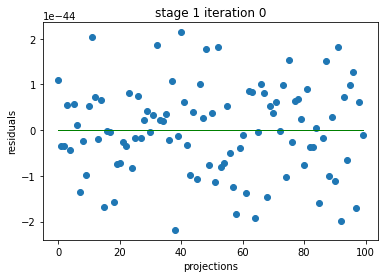

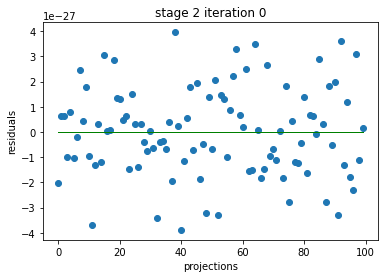

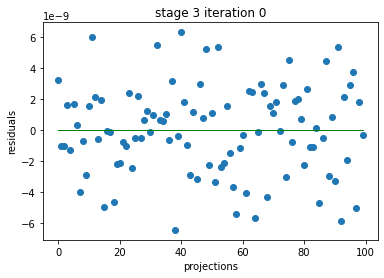

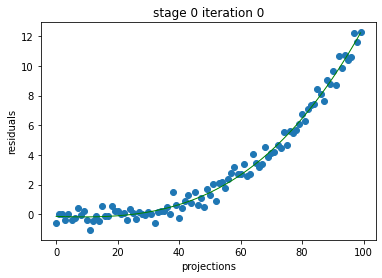

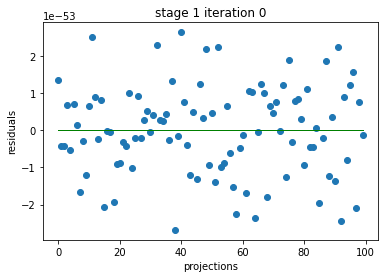

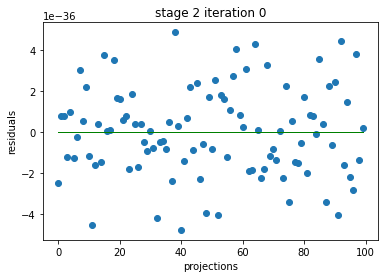

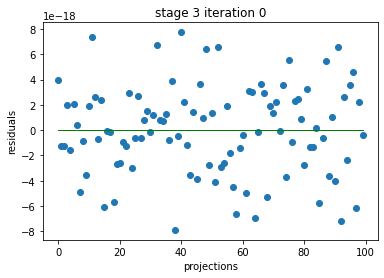

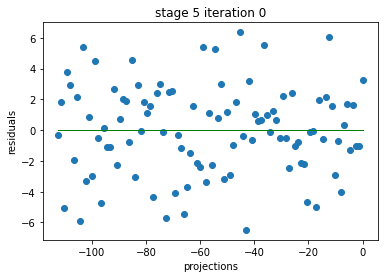

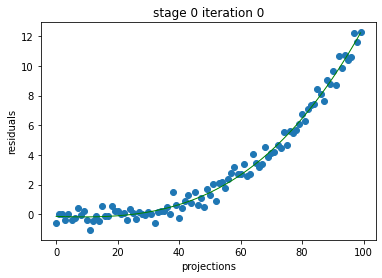

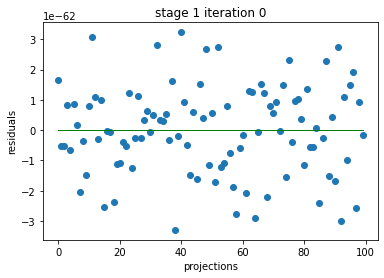

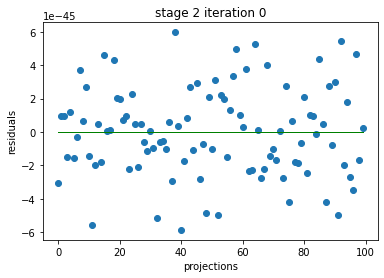

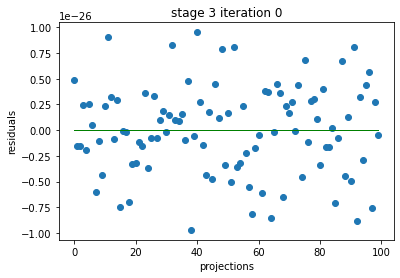

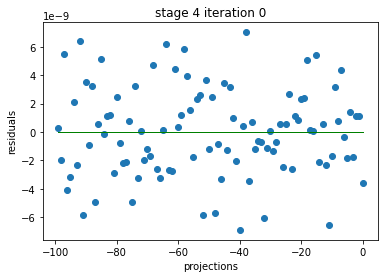

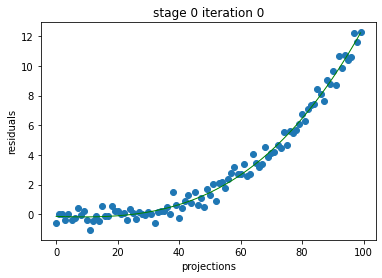

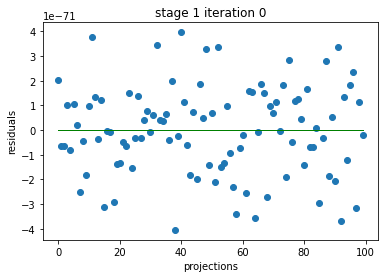

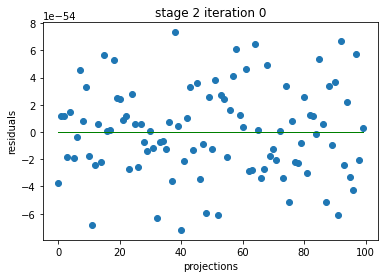

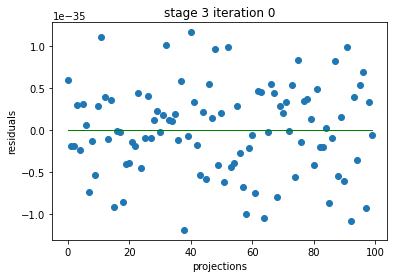

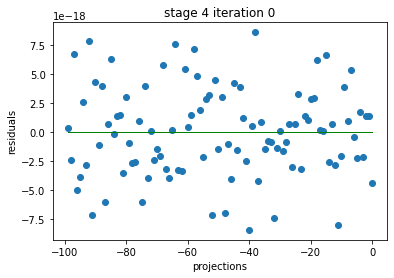

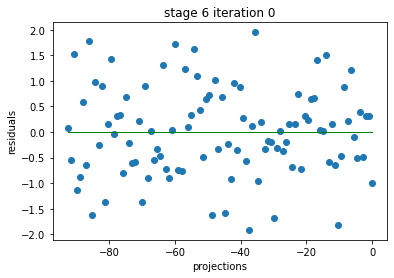

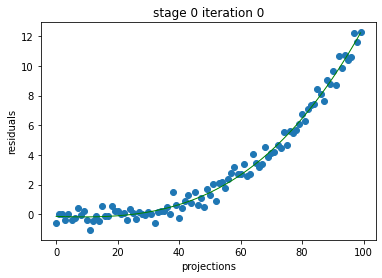

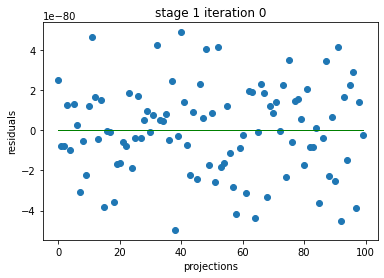

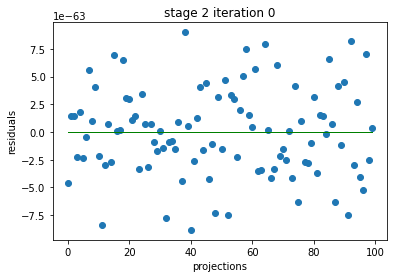

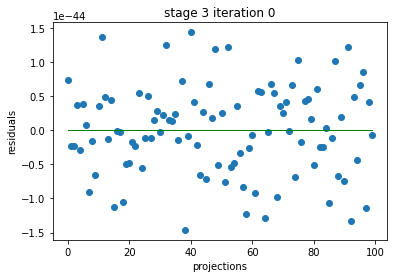

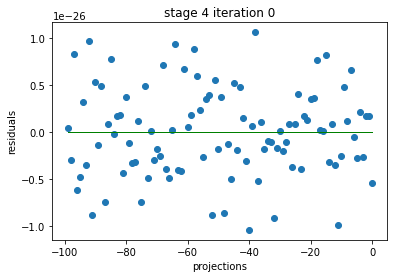

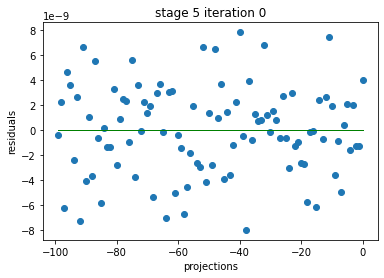

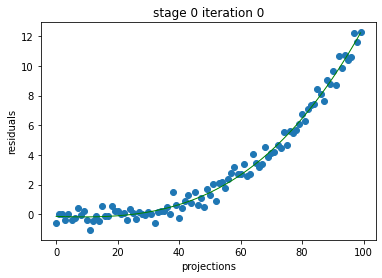

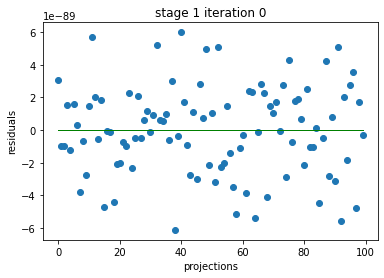

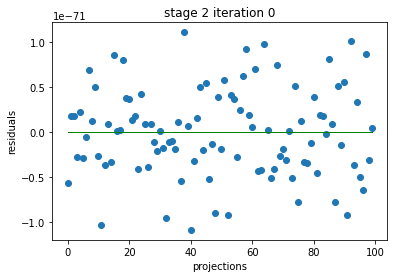

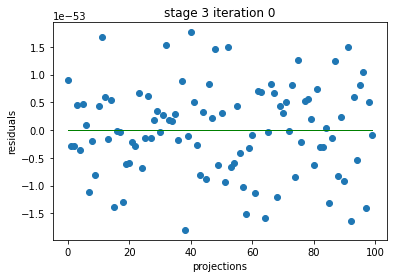

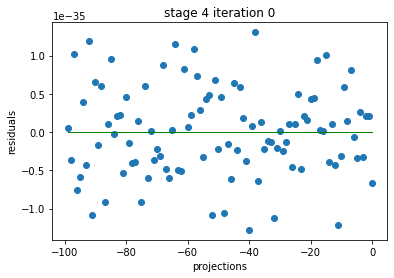

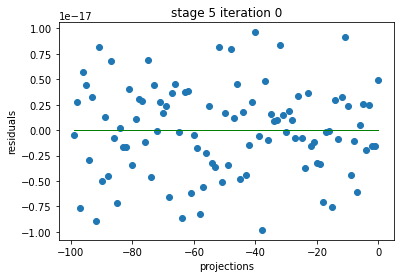

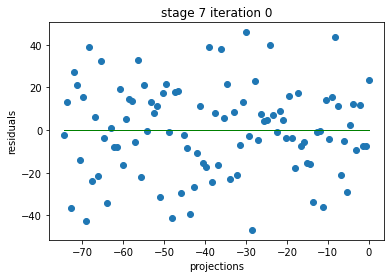

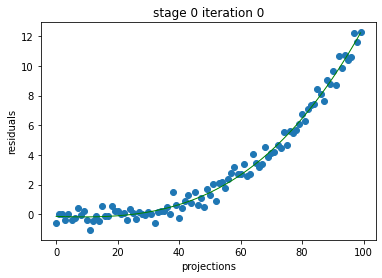

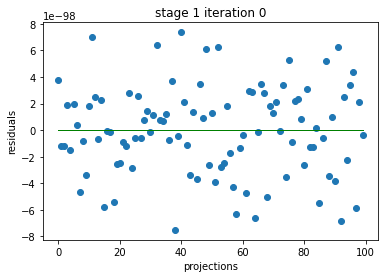

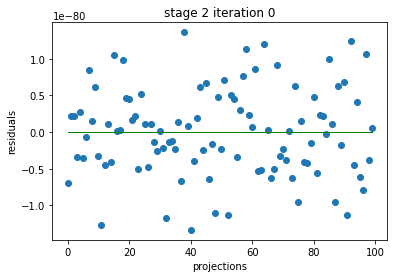

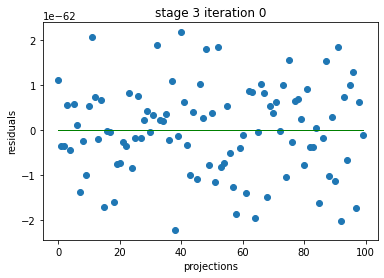

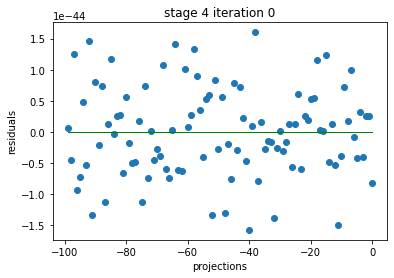

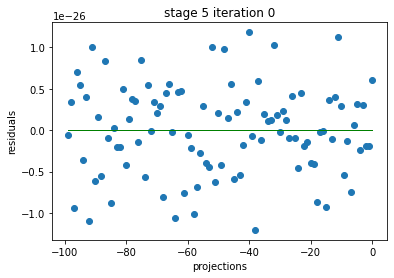

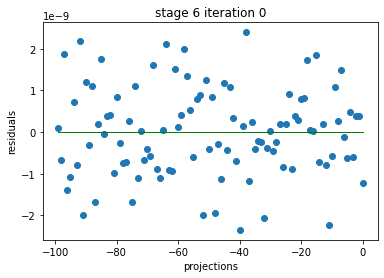

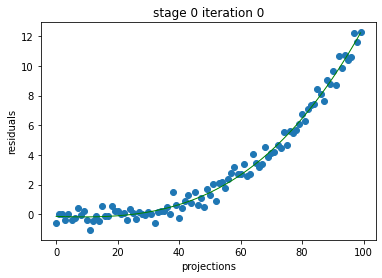

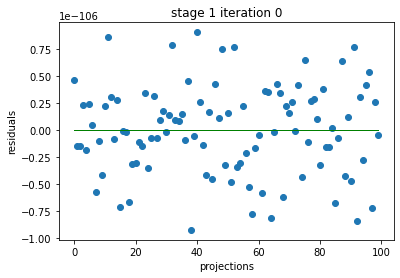

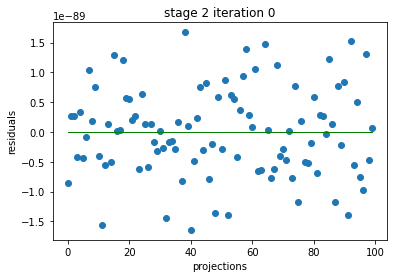

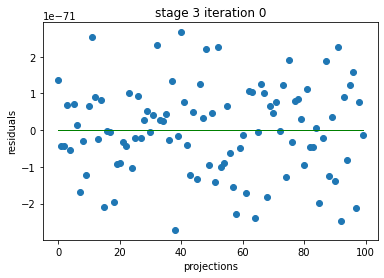

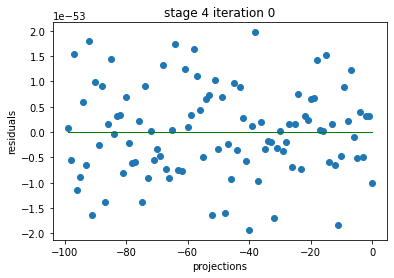

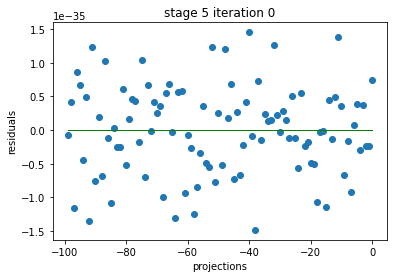

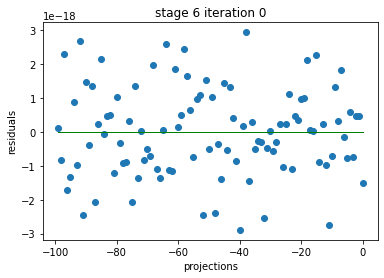

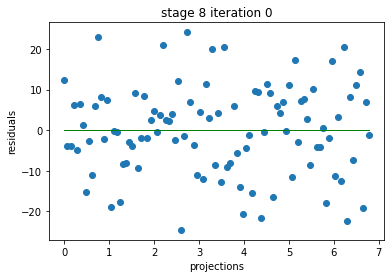

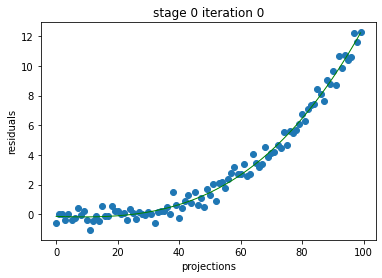

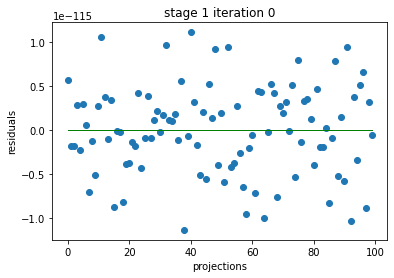

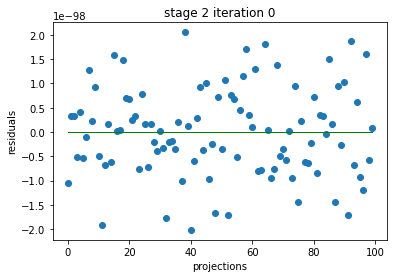

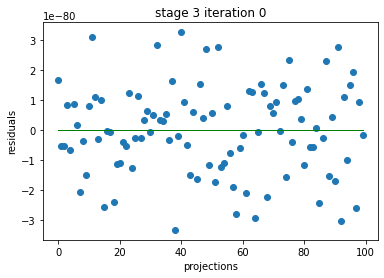

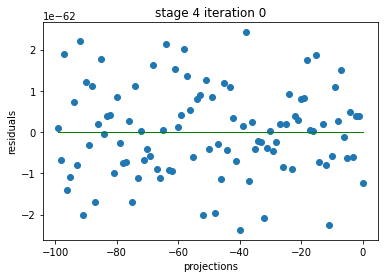

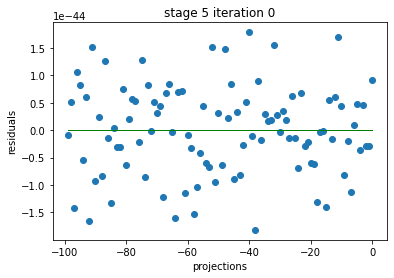

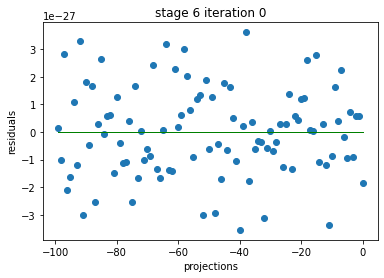

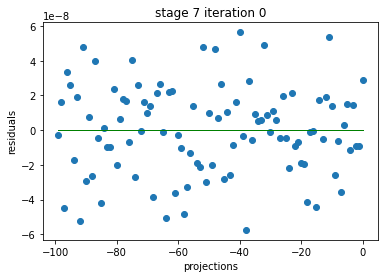

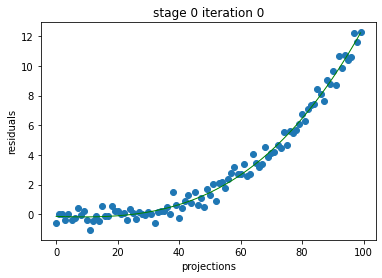

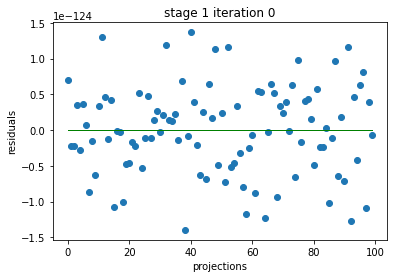

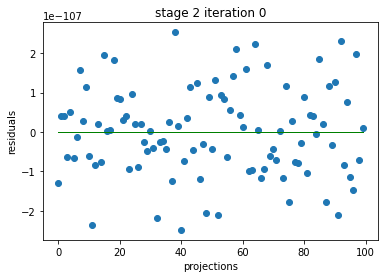

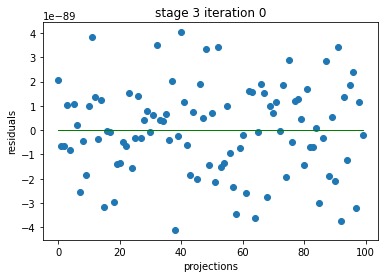

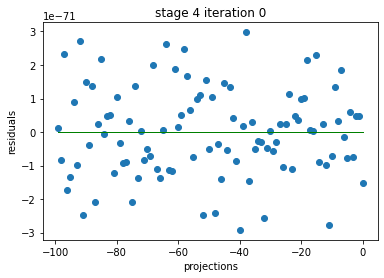

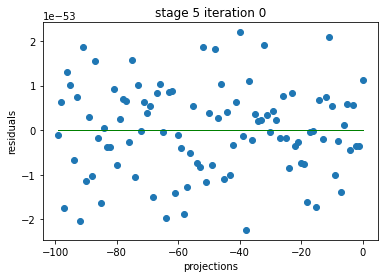

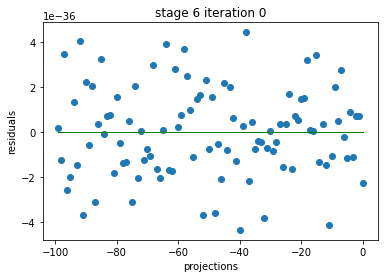

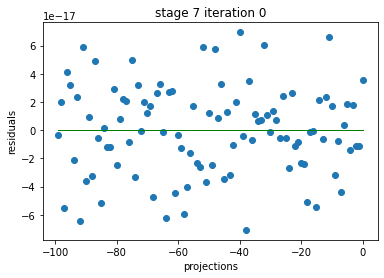

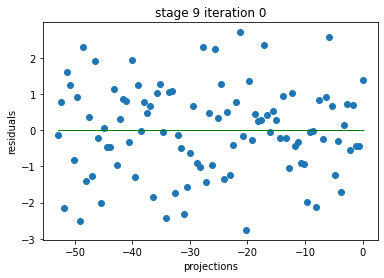

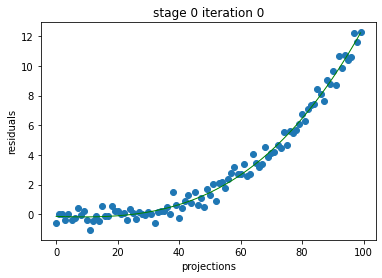

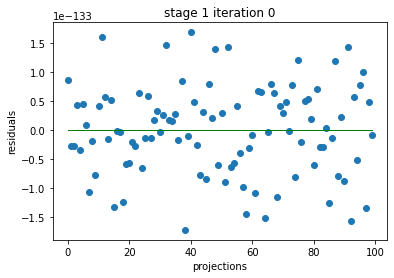

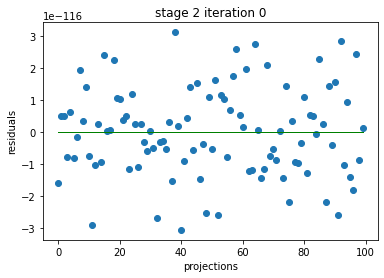

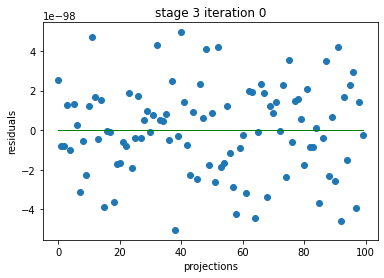

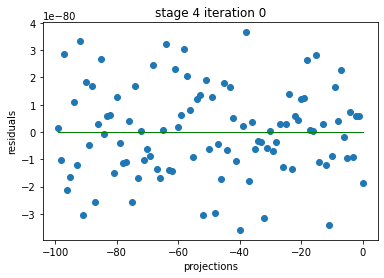

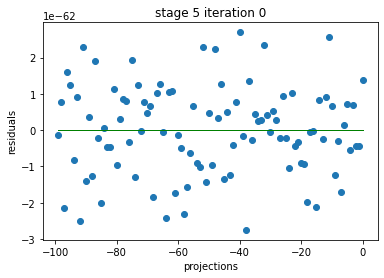

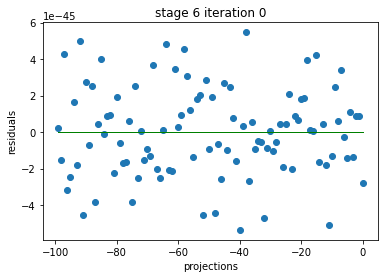

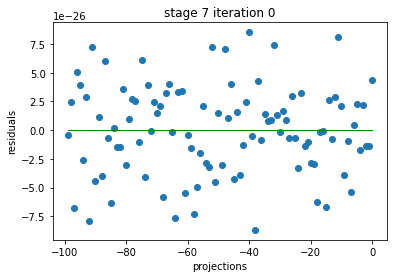

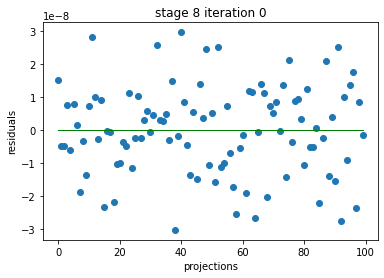

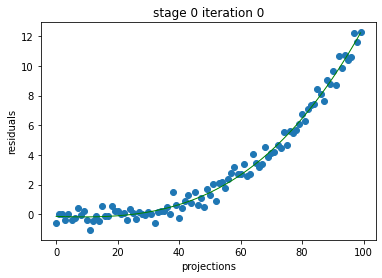

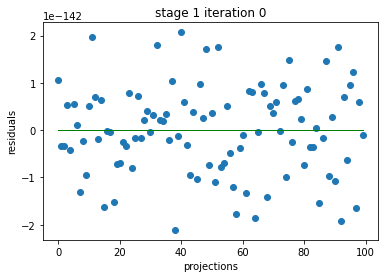

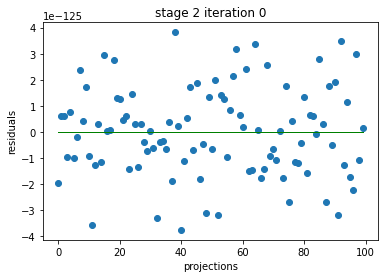

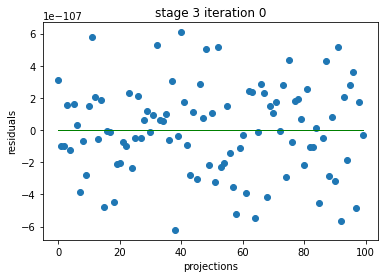

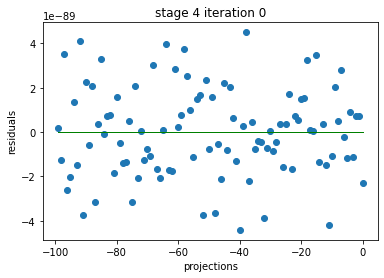

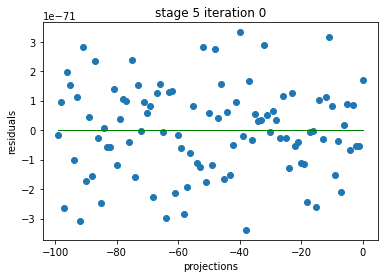

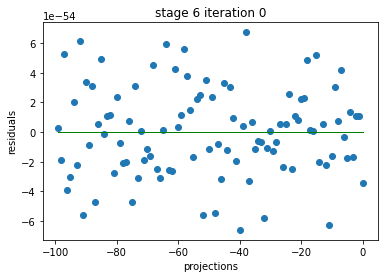

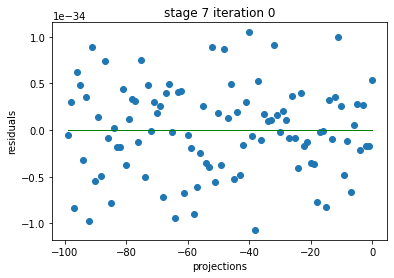

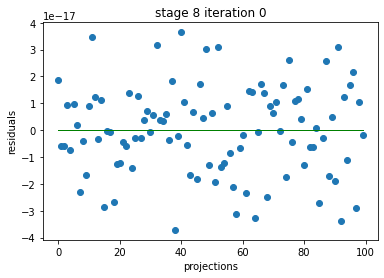

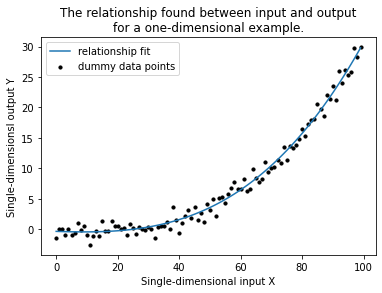

In [10]:

X = np.arange(100).reshape(100, 1)
Y = (3*X**3 - 2*X)[:,0]/100000 + np.random.randn(100)

estimator = PPR()
estimator.fit(X, Y)

plt.scatter(X, Y, c='k', s=10, label='dummy data points')
plt.plot(estimator.predict(X), label='relationship fit')
plt.legend()

plt.title('The relationship found between input and output\nfor a ' +
	'one-dimensional example.')
plt.xlabel('Single-dimensional input X')
plt.ylabel('Single-dimensionsl output Y')
plt.show()